## Modelo de regresion lineal sin los supuestos clasicos
Debido a que los supuestos en muchos casos suelen ser muy específicos, existen casos en los que se encuentra que no se cumplen con estos supuestos. Por ello, es importante saber identificarlos y encontrar una solucion a los siguientes:
1. Heterocedasticidad: varianza cambiante en el tiempo (supuesto 3)
2. Autocorrelacion: correlacion con rezagos (supuesto 3)
3. Endogeneidad en los regresores: correlacion de un regresor con el error (supuesto 2)
4. No normalidad en los errores: (supuesto 5)

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson

import warnings
warnings.simplefilter("ignore")

### Heterocedasticidad

### Autocorrelacion
Se usara las series macroeconomicas de los Estados Unidos

In [63]:
dta = sm.datasets.macrodata.load_pandas()
dta.data.to_csv("./data/macrodata.csv")

dta.data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [224]:
X = dta.data[["realgdp"]]; y = dta.data["cpi"]
X = np.log(X); y = np.log(y)

X = X.diff(periods=4)*100; X = X.dropna()
y = y.diff(periods=4)*100; y = y.dropna()

# Añadir constante
X = sm.add_constant(X)

In [225]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     7.333
Date:                Sat, 31 Dec 2022   Prob (F-statistic):            0.00737
Time:                        17:10:26   Log-Likelihood:                -480.93
No. Observations:                 199   AIC:                             965.9
Df Residuals:                     197   BIC:                             972.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7062      0.324     14.526      0.0

Se puede definir la existencia de autocorrelacion mediante lo siguiente:
1. ACF, PACF
2. Test de Durbin-Watson
3. Test de Breusch-Pagan

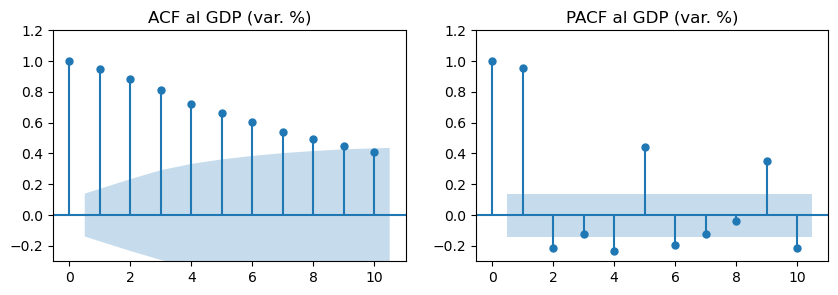

In [280]:
# Test 1
fig, ax = plt.subplots(1, 2, figsize=(10,3))

plot_acf(y, ax=ax[0], lags=10, title="ACF al GDP (var. %)", alpha=0.05)
plot_pacf(y, ax=ax[1], lags=10, title="PACF al GDP (var. %)", alpha=0.05)

ax[0].set_ylim([-0.3, 1.2])
ax[1].set_ylim([-0.3, 1.2])

plt.savefig("./figures/acf_pacf_gdp.pdf")
plt.show()

In [228]:
# Test 2
np.round(durbin_watson(results.resid), 3) # Autocorrelacion positiva

0.097

In [275]:
# Test 3
def test_breusch_godfrey(model_results, maxlags):
    list = []

    for i in range(1, maxlags+1):
        values = acorr_breusch_godfrey(model_results, nlags=i)
        list.append([i, values[0], values[1]])
    
    table = pd.DataFrame(list, columns=["lags", "LM", "pvalue"])
    table.set_index("lags", inplace=True)
    
    # P-value < pvalue 
    table[f"pv<0.1"] = table["pvalue"]<0.1
    table[f"pv<0.05"] = table["pvalue"]<0.05
    table[f"pv<0.01"] = table["pvalue"]<0.01

    # Rounding
    table["LM"] = np.round(table["LM"], 3)
    table["pvalue"] = np.round(table["pvalue"], 3)

    return table


# La hipotesis nula es de no autocorrelacion
# Se rechaza la no autocorrelacion hasta 5 rezagos. 
test_breusch_godfrey(results, maxlags=5)

,LM,pvalue,pv<0.1,pv<0.05,pv<0.01
lags,,,,,
1,0.563,0.453,False,False,False
2,3.988,0.136,False,False,False
3,12.778,0.005,True,True,True
4,35.970,0.000,True,True,True
5,36.553,0.000,True,True,True


Inclusión de un rezago

In [271]:
X = dta.data[["realgdp"]]; y = dta.data["cpi"]
X = np.log(X); y = np.log(y)

X = X.diff(periods=4)*100 
y = y.diff(periods=4)*100

X["cpi(-1)"] = y.shift(1) # Añadiendo un rezago
X = X.dropna(); y = y.dropna()

# Añadir constante
X = sm.add_constant(X)

y = y[1:]

In [272]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     1271.
Date:                Sat, 31 Dec 2022   Prob (F-statistic):          1.41e-112
Time:                        17:18:06   Log-Likelihood:                -220.83
No. Observations:                 198   AIC:                             447.7
Df Residuals:                     195   BIC:                             457.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3262      0.135     -2.420      0.0

In [276]:
print("Parece solucionar un poco la autocorrelacion en los dos primeros rezagos")
test_breusch_godfrey(results, maxlags=3)

Parece solucionar un poco la autocorrelacion en los dos primeros rezagos


,LM,pvalue,pv<0.1,pv<0.05,pv<0.01
lags,,,,,
1,0.563,0.453,False,False,False
2,3.988,0.136,False,False,False
3,12.778,0.005,True,True,True


### Endogeneidad

### No normalidad en errores

### Referencias:
* https://www.statsmodels.org/dev/diagnostic.html